In [29]:
import os
img_dir = "/content/nst"
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

In [30]:
"""
# copy them in folder in nst folder (neural transfer style)
!cp "/content/ytu-cloud.jpeg" "/content/nst"
!cp "/content/Vincent-Van-Gogh-Starry-Night.jpg" "/content/nst"
"""

In [135]:
# path to the images
CONTENT_IMAGE_PATH = "/content/ytu-cloud.jpeg"
STYLE_IMAGE_PATH = "/content/Vincent-Van-Gogh-Starry-Night.jpg"

In [136]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image # import PIL.Image may be better in case of possibility of a module masks Image (namespace conflict)
import time

In [137]:
%tensorflow_version 1.x # in google colab, use 1.x version
import tensorflow as tf

from tensorflow.python.keras.preprocessing import image as keras_preprocessing_image
from tensorflow.python.keras import models, layers, losses, backend

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # in google colab, use 1.x version`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [139]:
tf.enable_eager_execution()
print(f"Eager execution:{tf.executing_eagerly()}")

Eager execution:True


In [142]:
def load_img(path):
  max_dim = 512
  img = Image.open(path)
  long_ = max(img.size)
  scale = max_dim / long_
  img = img.resize((round(img.size[0] * scale), (round(img.size[1] * scale))), Image.ANTIALIAS)

  img = keras_preprocessing_image.img_to_array(img)

  img = np.expand_dims(img, axis=0) # add batch dimension
  return img

In [143]:
def show_img(img, title=None):
  out = np.squeeze(img, axis=0) # remove batch dimension
  out = out.astype("uint8") # normalize to display
  plt.imshow(out)
 
  if title != None:
    plt.title(title)
  else:
    plt.title("Uploaded Image")
  plt.axis("off")
  plt.imshow(out)

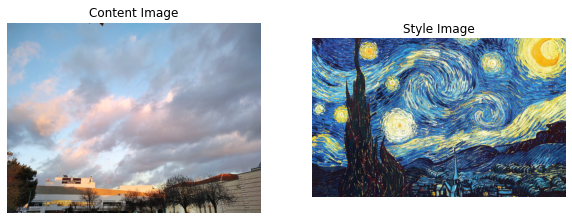

In [144]:
plt.figure(figsize=(10, 10))

content_img = load_img(CONTENT_IMAGE_PATH).astype("uint8")
style_img = load_img(STYLE_IMAGE_PATH).astype("uint8")

plt.subplot(1, 2, 1)
show_img(content_img, "Content Image")

plt.subplot(1, 2, 2)
show_img(style_img, "Style Image")

In [145]:
# vgg nets trained on img with each channel normalized by mean = [103.939, 116.779, 123.68] + BGR channels

def load_and_process_img(path):
  img = load_img(path)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

In [162]:
# to view results of optimization deprocess img
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
    # make sure that length of x.shape is 3 
  assert len(x.shape) == 3, ("Input to deprocess img of dimension must be"
    "[1, height, width, channel] or [height, width, channel]")

  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocess")

  # perform deprocessing
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68

  x = x[:, :, ::-1] # inverse channel

  # processed/optimized img can take values minus to positive infinite
  # so adjust range
  x = np.clip(x, 0, 255).astype("uint8")
  return x

In [175]:
# feature map location we want
content_layers = ["block5_conv2"]

# style layers we want (first conv layers of blocks 1-5)
style_layers = ["block" + str(i+1) + "_conv1" for i in range(5)]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [164]:
def get_model():

  # load trained vgg19
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights="imagenet")
  vgg.trainable=False

  # get output layers of style & content, then concat and get model outputs
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs

  return models.Model(vgg.input, model_outputs)

In [165]:
def content_loss(content, target):
  # tf.reduce_mean computes the mean across the dimension
  return tf.reduce_mean(tf.square(content - target))

In [176]:
def gram_matrix(input_tensor):
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]

  # gram matrix = matrix . transpose(matrix)
  gram = tf.matmul(a, a, transpose_a=True)

  return gram / tf.cast(n, tf.float32)

In [167]:
def style_loss(style, gram_target):
  height, width, channels = style.get_shape().as_list()
  gram_style = gram_matrix(style)

  return tf.reduce_mean(tf.square(gram_style - gram_target))

In [168]:
def get_feature_representations(model, style_path, content_path):

  # load images
  content_image = load_and_process_img(CONTENT_IMAGE_PATH)
  style_image = load_and_process_img(STYLE_IMAGE_PATH)

  # content and style features
  content_outputs = model(content_image)
  style_outputs = model(style_image)

  # get features for style and content
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]

  return style_features, content_features

In [169]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  style_weight, content_weight = loss_weights
  
  model_outputs = model(init_image) # using eager enables to call model like a function 

  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]

  style_score, content_score = 0, 0

  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer * content_loss(comb_content[0], target_content)

  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * style_loss(comb_style[0], target_style)

  style_score *= style_weight
  content_score *= content_weight

  # total loss
  loss = style_score + content_score

  return loss, style_score, content_score

In [170]:
def compute_grads(cfg):
  with tf.GradientTape() as tape:
    all_loss = compute_loss(**cfg)

  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg["init_image"]), all_loss

In [178]:
import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2): 
  
  # not wanted to train layers 
  model = get_model() 
  for layer in model.layers:
    layer.trainable = False
  
  # style and content feature representations
  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  # initial image
  init_image = load_and_process_img(content_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)

  # optimizer
  opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

  # to display intermediate images 
  iter_count = 1
  
  # Store best results
  best_loss, best_img = float('inf'), None
  
  # handsome config 
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
    
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []

  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    
    if loss < best_loss:
      best_loss = loss # update loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()
      
      plot_img = init_image.numpy() # get numpy array
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
      
  return best_img, best_loss 

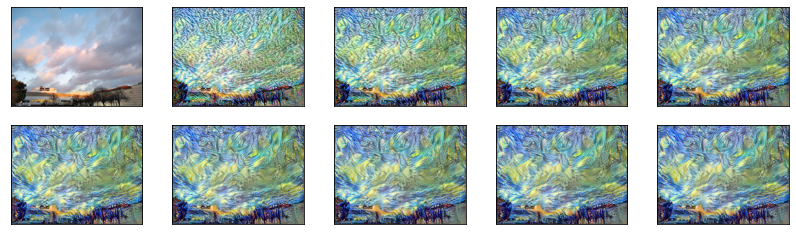

In [179]:
best, best_loss = run_style_transfer(CONTENT_IMAGE_PATH, STYLE_IMAGE_PATH, num_iterations=1000)

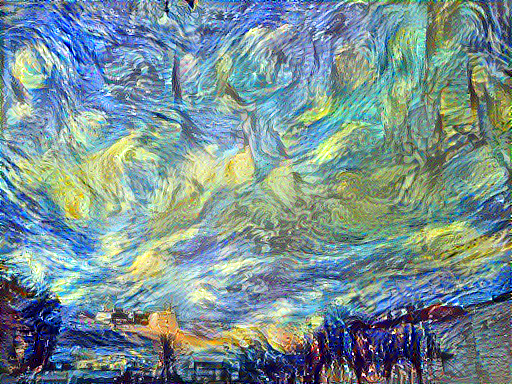

In [180]:
Image.fromarray(best)

In [181]:
def show_results(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path) 
  style = load_img(style_path)

  plt.subplot(1, 2, 1)
  show_img(content, 'Content Image')

  plt.subplot(1, 2, 2)
  show_img(style, 'Style Image')

  if show_large_final: 
    plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

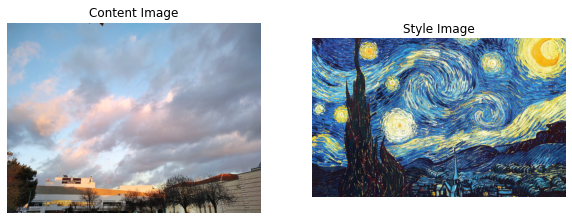

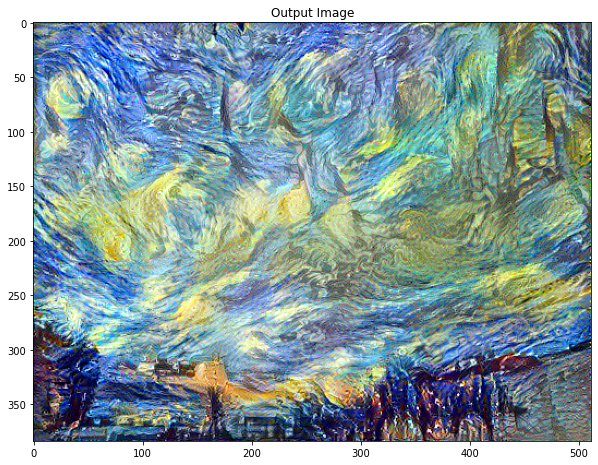

In [182]:
show_results(best, CONTENT_IMAGE_PATH, STYLE_IMAGE_PATH)